# Example of Fitting Custom Data/Spectra

This notebook provides a quick overlook of the fitting code in SunXspex and some examples of fitting user defined custom data instead of the data coming from files that already have loader classes.

We also use a user defined function.

The fitting code is not optimised for this purpose but it can be used. This notebook isn't necessarily here to show or recommend that data of this type be fitted using theis code. This is to show an example of how a user might start to organise their own (X-ray?) spectroscopic data in the form that this software was designed to work with and how to provide the fitting class with the needed dictionary structure.

This Notebook has been run on my Macbook (processor: Intel i5-7360U @ 2.3 GHz).

**For a more explained demonstration of the general fitting process and capabilities see the NuSTAR fitting example.**

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from sys import path as sys_path
sys_path.append('../sunxspex')
from sunxspex.sunxspex_fitting.fitter import SunXspex

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

## Set up some plotting numbers

In [4]:
spec_plot_size = (16,12)
spec_font_size = 20
default_text = 10
ylims = [1,2e4]

***

## Let's fit data with a two Gaussian profile with added noise

First, we can add a Gaussian model to the fitting namespace to fit our data.

In [5]:
# import methods to add or delete methods from the fitting namespace
from sunxspex.sunxspex_fitting.fitter import add_photon_model, del_photon_model

# define a gaussian function
def gauss(a, b, c, energies=None):
    """Gaussian function.
    
    Note: Parameters are args and energies (x-axis input) is a kwarg with None as default.
    
    Parameters
    ----------
    a,b,c : floats
            The scaler, mean, and standard deviation of the gaussian model output, respectively.
    
    energies : 2d array
            An array where each entry is the two energy bin edge values.
            
    Returns
    -------
    A 1d array output of the model.
    """
    mid_x = np.mean(energies, axis=1) 
    return a * np.exp(-((mid_x-b)**2/(2*c**2)))

# make sure to delete any existing model already there (e.g., if this exact cell is getting run multiple times)
del_photon_model("gauss")

# add the model to be used in fitting
add_photon_model(gauss)

gauss is not in `defined_photon_models` to be removed.
Model gauss added.


Now we can define the data. 

In [6]:
# Create channel bins and the fake data components, here we go for 2 Gaussians and noise
maxi, step = 1e3, 1
chan_bins = np.stack((np.arange(0,maxi, step), np.arange(step,maxi+step, step)), axis=-1)
gauss_mod1 = gauss(1.3e4, 350, 60, energies=chan_bins)
gauss_mod2 = gauss(3e3, 600, 60, energies=chan_bins)
noise = np.random.randint(low=10, high=100, size=(len(chan_bins)))/100*5

fake_data = gauss_mod1 + gauss_mod2 + noise

# create a simple dictionary with teh custom data information
custom_dict = {"count_channel_bins":chan_bins, 
               "counts":fake_data
              } # counts with noise

The ```"count_channel_bins"``` are the x-axis bin edges and the ```"counts"``` are the corresponding y-axis values.

The above two dictionary entries are labelled "essential" and is only because we need x/y values to fit. The other keys that can be set are:

* "photon_channel_bins"
* "photon_channel_mids"
* "photon_channel_binning"
* "count_channel_mids"
* "count_channel_binning"
* "count_error"
* "count_rate"
* "count_rate_error"
* "effective_exposure"
* "srm"
* "extras"
                        
but if they are not provided then they are assigned defaults. The ```"photon_channel_bins"``` are set to equal the ```"count_channel_bins"```; the ```"photon_channel_mids"``` and ```"count_channel_mids"``` are set to the ```"count_channel_bins"``` mid-points; ```"photon_channel_binning"```, ```"count_channel_binning"```, ```"count_error"```, and ```"count_rate_error"``` are set to arrays the same length as ```"count_channel_bins"``` with all values equal to one; the ```"count_rate"``` entry is set to the ```"counts"``` entry with the ```"effective_exposure"``` being set to one and the ```"srm"``` being made equal to the identity matrix. 

The ```"extras"``` key is assigned an empty dictionary but can host other information for the user's convenience or can be provided with background keys ("background_counts", "background_count_error", "background_rate", "background_rate_error", "background_effective_exposure") for the custom data to be used when fitting and plotting.

Obviously when fitting the data directly (i.e., the "photon" spectrum is the same as the "counts" and "count rate" spectrum) then this fitting software is sub-optimal since there is an identity matrix multiplication on every model calculation. This conversion is needed when fitting X-ray data, but not necessary elsewhere; however, this is just a simple case of fitting custom data here. Obviously if you have X-ray data, or need to convert to photon space to counts space using a spectral response matrix then this is the software for you.

The expected conversion from a photon model to a count model is:

* counts_rate_model [counts s^2] = photon_model [photons s^2 cm^-2] # spectral_response_matrix [counts photon^-1 cm^2]

Going back to this example, to help fit the noise added to the fake data we simply take the mean of the added noise and can include that in the model. This especially helps in the sections of the data where the noise is dominant. Obviously there are more robust ways to do this but this will do here.

In [7]:
noise_constant = np.mean(noise)

We provide the fitting tools with this dictionary

In [8]:
custom_spec = SunXspex(custom_dict)

# assign the fitting code's active model to be a combination of ones you defined
custom_spec.model = f"gauss+gauss+{noise_constant}"

Looking at the data, assign some reasonable boundaries/starting values and change from the default fit statistic.

By inspecting the data, we set the the a, b, and c values to start at 1000 and 400, and 100 with bounds (5e2, 5e3), (2e2, 1e3), and (1e1, 2e2), respectively, for the first Gaussian.

We will freeze the second Gaussian's parameters for the first part of the fit but a, b, and c will be set to 500 and 600, and 60 with bounds (1e2, 1e3), (2e2, 1e3), and (1e1, 1e2), respectively, when they are freed for their fitting. 

We can then check the parameters...

In [9]:
# define a large enough range to be sure the answer is in there somewhere
custom_spec.params["a1_spectrum1"] = [1e4,(5e2, 5e4)]
custom_spec.params["b1_spectrum1"] = [400,(2e2, 1e3)]
custom_spec.params["c1_spectrum1"] = [100,(1e1, 2e2)]

# see parameters
print(custom_spec.params)

             Status    Value            Bounds       Error
a1_spectrum1   free  10000.0  (500.0, 50000.0)  (0.0, 0.0)
b1_spectrum1   free    400.0   (200.0, 1000.0)  (0.0, 0.0)
c1_spectrum1   free    100.0     (10.0, 200.0)  (0.0, 0.0)
a2_spectrum1   free      1.0       (0.0, None)  (0.0, 0.0)
b2_spectrum1   free      1.0       (0.0, None)  (0.0, 0.0)
c2_spectrum1   free      1.0       (0.0, None)  (0.0, 0.0)


Now all we do is fit. Since we can see from the data that the different gaussian profiles dominate at different energy ranges, we can fit each over their respsective ranges before performing a total fit.

Freeze the second Gaussian's parameters (its values are low enough to not contribute a lot to the overall model here by default) and fit between 150$-$380 "keV".

In [10]:
# roughly first Gaussian fitting range
custom_spec.energy_fitting_range = [150,380]
custom_spec.params["a2_spectrum1"] = "freeze"
custom_spec.params["b2_spectrum1"] = "freeze"
custom_spec.params["c2_spectrum1"] = "freeze"

# fit
minimiser_results = custom_spec.fit()

Now freeze the first Gaussian's parameters while freeing the second (providing guess starting positions and bounds) and fit between 550$-$800 "keV".

In [11]:
# roughly second Gaussian fitting range
custom_spec.energy_fitting_range = [550,800]
custom_spec.params["a1_spectrum1"] = "freeze"
custom_spec.params["b1_spectrum1"] = "freeze"
custom_spec.params["c1_spectrum1"] = "freeze"
custom_spec.params["a2_spectrum1"] = ["free", 5e3,(1e3, 1e4)]
custom_spec.params["b2_spectrum1"] = ["free", 600,(2e2, 1e3)]
custom_spec.params["c2_spectrum1"] = ["free", 50,(1e1, 1e2)]

# fit
minimiser_results = custom_spec.fit()

Now free everything and fit over the full energy range of thee signals, 150$-$800 "keV".

In [12]:
# full range
custom_spec.energy_fitting_range = [150,800]
custom_spec.params["a1_spectrum1"] = "free"
custom_spec.params["b1_spectrum1"] = "free"
custom_spec.params["c1_spectrum1"] = "free"

# fit
minimiser_results = custom_spec.fit()

We can plot the result and have complete control other the resulting plot. Here we plot the general output then change the y-scale back to linear just to observe the fake data.

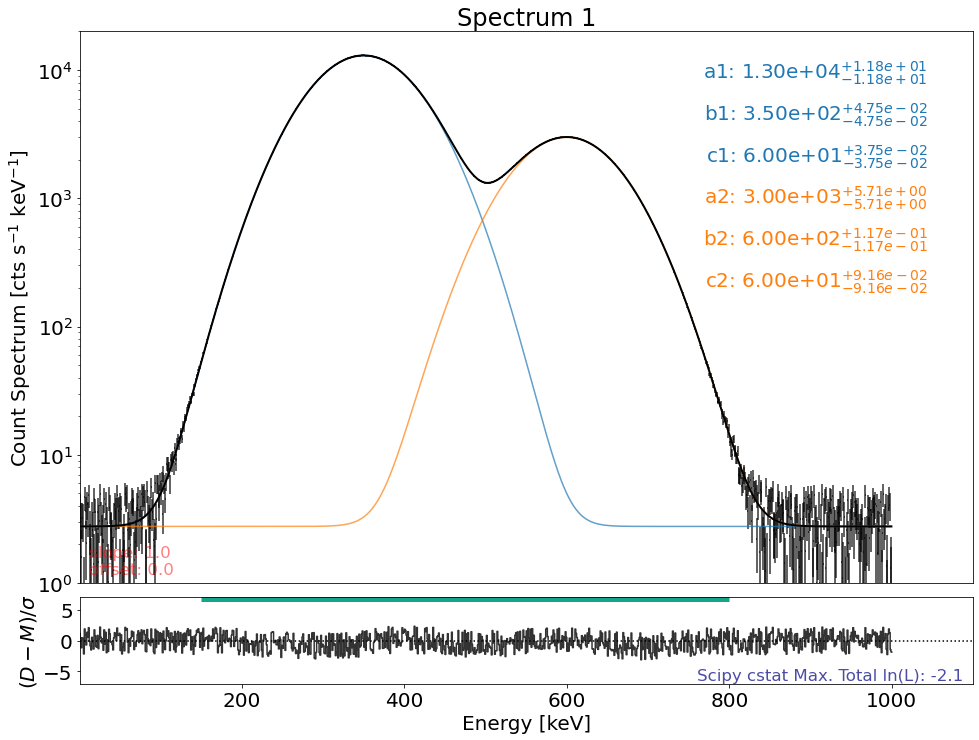

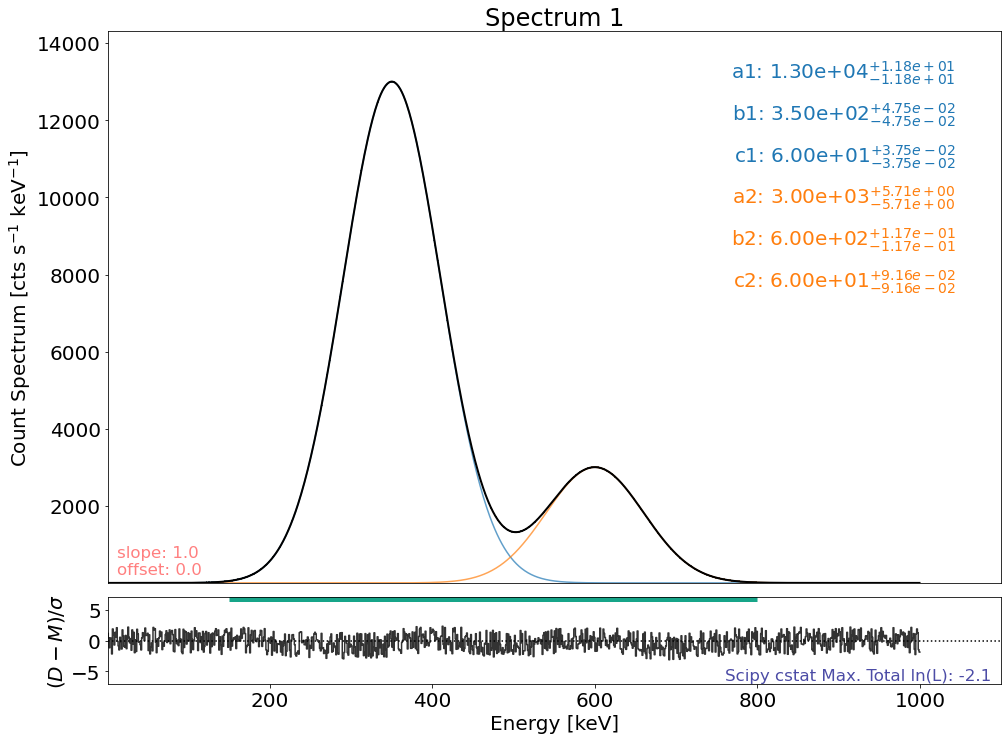

             Status         Value             Bounds  \
a1_spectrum1   free  13000.305512   (500.0, 50000.0)   
b1_spectrum1   free    349.995778    (200.0, 1000.0)   
c1_spectrum1   free     60.001191      (10.0, 200.0)   
a2_spectrum1   free   2999.767076  (1000.0, 10000.0)   
b2_spectrum1   free    600.007041    (200.0, 1000.0)   
c2_spectrum1   free     60.022121      (10.0, 100.0)   

                                                     Error  
a1_spectrum1      (11.772185809462048, 11.772185809462048)  
b1_spectrum1      (0.0474886601926014, 0.0474886601926014)  
c1_spectrum1  (0.037491404268050844, 0.037491404268050844)  
a2_spectrum1        (5.712630036505375, 5.712630036505375)  
b2_spectrum1    (0.11679790955525556, 0.11679790955525556)  
c2_spectrum1    (0.09156918496235616, 0.09156918496235616)  


In [13]:
# plot the normal output
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = custom_spec.plot()
    
axes[0].set_ylim(ylims)
plt.show()
plt.rcParams['font.size'] = default_text


# change the y-scale back to linear
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = custom_spec.plot()
for a in axes:
    a.set_yscale("linear")
    
plt.show()
plt.rcParams['font.size'] = default_text

print(custom_spec.params)

The residuals are error normalised where the default errors in this simple case are assumed to be 1 for all values and so they do not tell much other than the absolute difference between the model and data.

Now maybe want to perform MCMC analysis with your model and the data...

In [15]:
# spread walkers around the minimiser value, common approach
mcmc_steps = custom_spec.run_mcmc(steps_per_walker=int(1e4), walker_spread="mag_order")

100%|████████████████████████████████████| 10000/10000 [01:04<00:00, 154.00it/s]


Evaluate the MCMC output and produce some useful plots

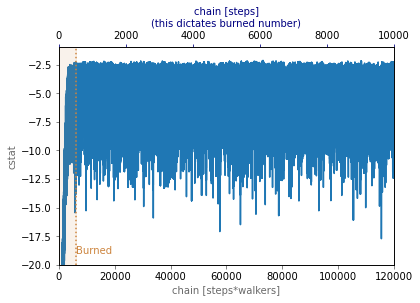

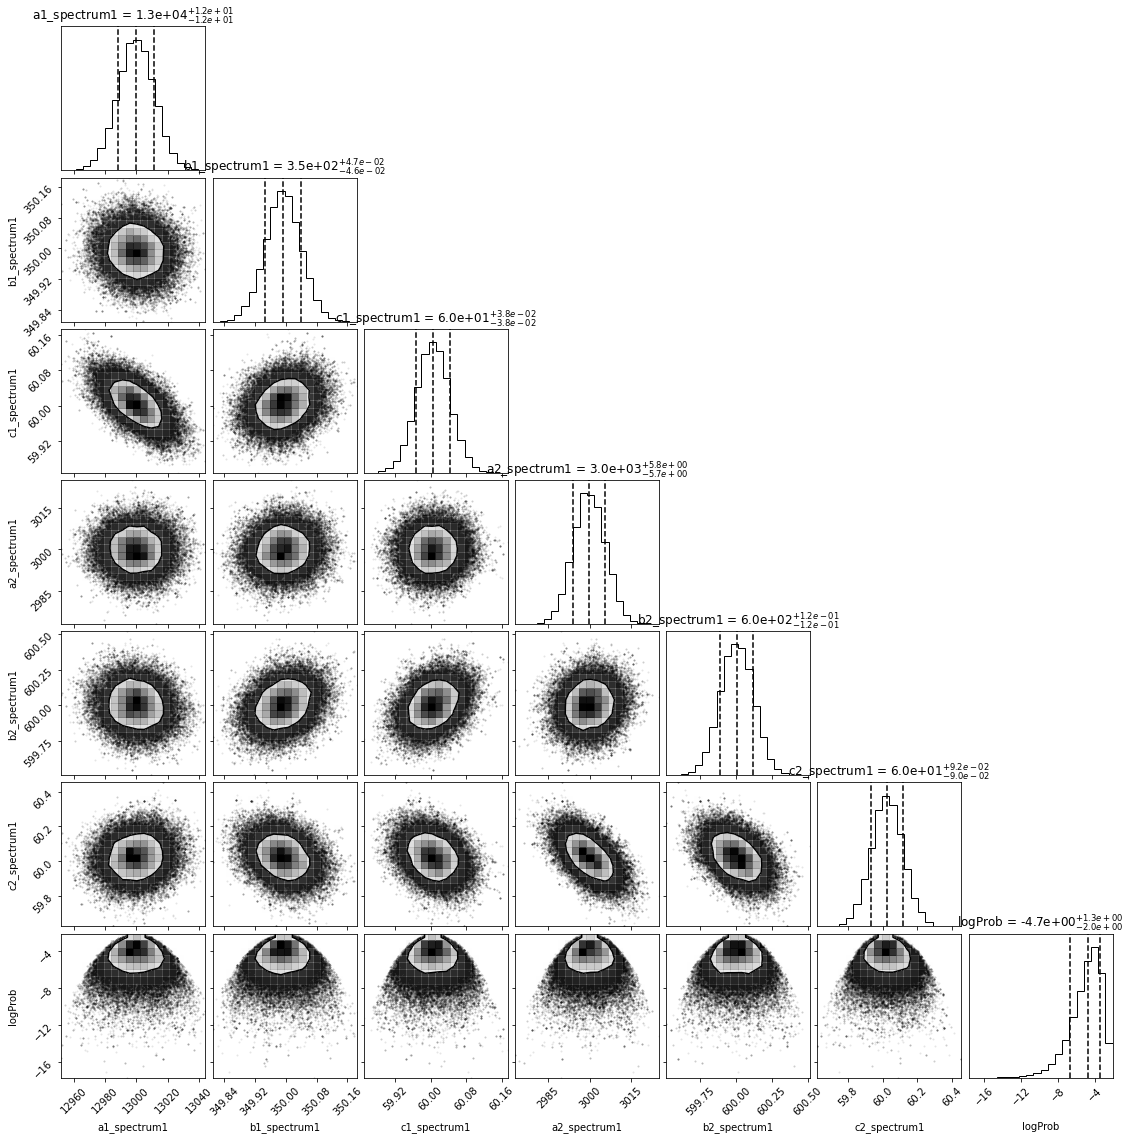

In [24]:
# burn the run in phase
custom_spec.burn_mcmc = 500

# look if the log probability chain has settled and decide if the number of samples burned was appropriate
plt.figure()
custom_spec.plot_log_prob_chain()
plt.ylim([-20,-1])
plt.show()

# produce a corner plot
corner_plot_custom_spec = custom_spec.corner_mcmc()

See the parameter results

In [18]:
print(custom_spec.params)

             Status         Value             Bounds  \
a1_spectrum1   free  12999.058722   (500.0, 50000.0)   
b1_spectrum1   free    349.993033    (200.0, 1000.0)   
c1_spectrum1   free     60.005009      (10.0, 200.0)   
a2_spectrum1   free   2999.493197  (1000.0, 10000.0)   
b2_spectrum1   free    600.006813    (200.0, 1000.0)   
c2_spectrum1   free     60.025576      (10.0, 100.0)   

                                                   Error  
a1_spectrum1    (11.603767449978477, 12.365499968173026)  
b1_spectrum1  (0.04510099559553282, 0.04586605054316806)  
c1_spectrum1  (0.03711981736798009, 0.03856913868884959)  
a2_spectrum1     (5.618004209759874, 5.9211644576321305)  
b2_spectrum1  (0.11526667250495848, 0.11716681060931933)  
c2_spectrum1  (0.09220708411820766, 0.09453802901415287)  


And the MCMC specific results

In [19]:
print(custom_spec.mcmc_table)

   Param        LowB       Mid       HighB      MaxLog  
------------ ---------- ---------- ---------- ----------
a1_spectrum1   12987.45   12999.06   13011.42   13001.26
b1_spectrum1     349.95     349.99     350.04     350.00
c1_spectrum1      59.97      60.01      60.04      60.01
a2_spectrum1    2993.88    2999.49    3005.41    2999.95
b2_spectrum1     599.89     600.01     600.12     599.99
c2_spectrum1      59.93      60.03      60.12      60.02


Plot the result (similar to earlier) but showing the MCMC runs.

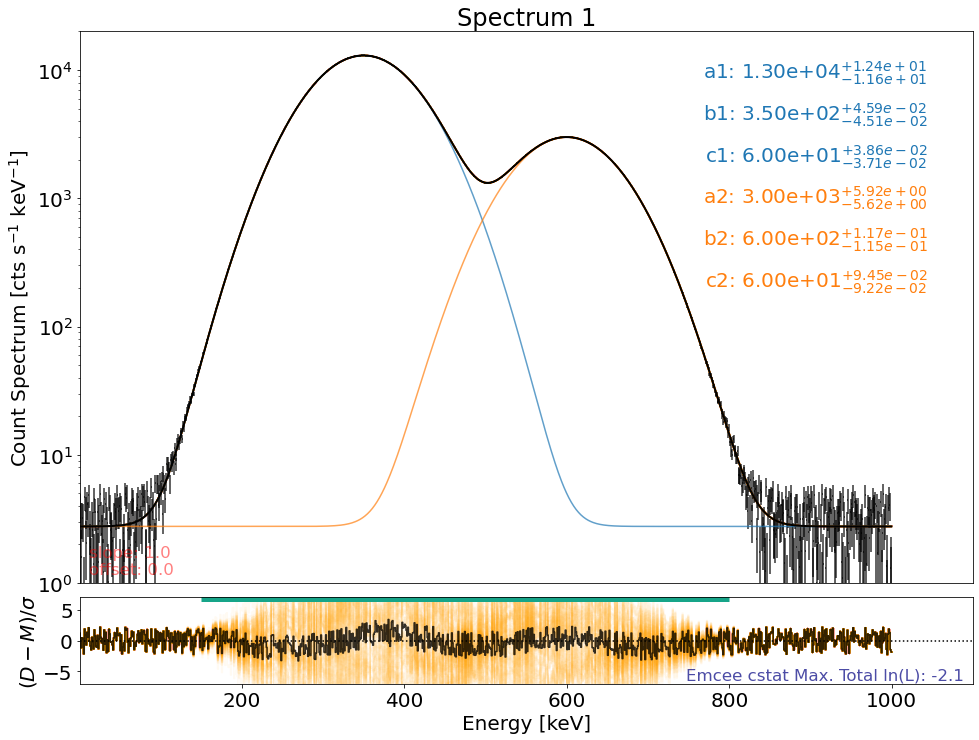

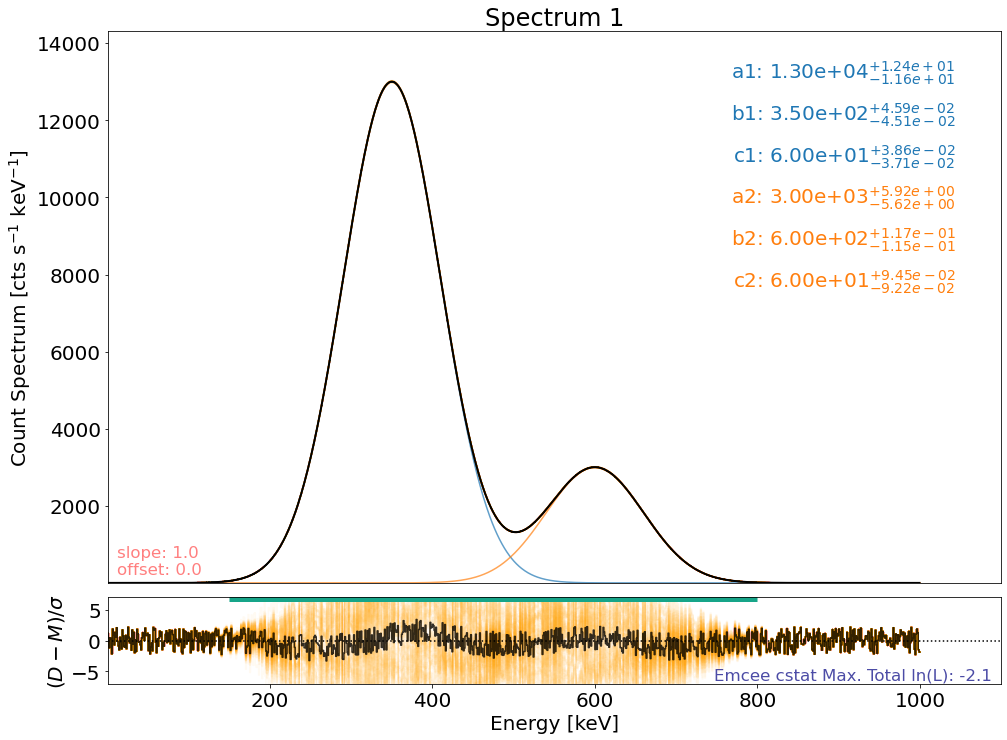

In [20]:
# plot the normal output
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = custom_spec.plot()
    
axes[0].set_ylim(ylims)
plt.show()
plt.rcParams['font.size'] = default_text

# change the y-scale back to linear
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = custom_spec.plot()
for a in axes:
    a.set_yscale("linear")
    
plt.show()
plt.rcParams['font.size'] = default_text

The MCMC runs in the residuals do not tell much since, again, they are error normalised where the default errors in this simple case are assumed to be 1 for all values.

## True value recovery

Not the worst recovery:

| Model Parameter  | True value   | Minimise fit       | MCMC                       |
| :---             |    :----:    |    :----:          |                     ----:  |
| a1               | 13000        | 13000.3$\pm$11.8   | 12999.0$^{+12.4}_{-11.6}$  |
| b1               | 350          | 350.00$\pm$0.05    | 349.99$^{+0.05}_{-0.05}$   |
| c1               | 60           | 60.00$\pm$0.04     | 60.01$^{+0.04}_{-0.04}$    |
| a2               | 3000         | 2999.8$\pm$5.7     | 2999.5$^{+5.9}_{-5.6}$     |
| b2               | 600          | 600.0$\pm$0.1      | 600.0$^{+0.1}_{-0.1}$      |
| c2               | 60           | 60.0$\pm$0.1       | 60.0$^{+0.1}_{-0.1}$       |

Again, this notebook isn't necessarily here to show or recommend that data of this type be fitted using theis code. This is to show an example of how a user might start to organise their own (X-ray?) spectroscopic data in the form that this software was designed to work with and how to provide the fitting class with the needed dictionary structure.

## Save and load

To save the session and results out:

```python
save_filename = "path/to/save/file/sunxspexCustomSpectralFitting.pickle"
custom_spec.save(save_filename)
```

The session can be loaded back in, and continued with, using the following code as an example,

```python
from sunxspex.sunxspex_fitting.fitter import load

custom_reloaded = load(save_filename)
```

***

***